In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

from pprint import pprint

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os

data_path = '/home/void/data/processed_files/'
#portable_path = r'D:\data_science\data\\'

files = os.listdir(data_path)
files = [file for file in files if file.endswith('.pkl')]

In [6]:
dfs = [pd.read_pickle(data_path + file) for file in files]

In [7]:
df = pd.concat(dfs)

In [8]:
# helper funcs

def convert_price(string):
    return float(string[1:])

def convert_response_time(datum):
    result = 0
    if type(datum) is str:
        try:
            result = float(datum[:-1])
        except:
            print(f'could not cast {datum} to float')
    elif type(datum) is int:
        result = float(datum)
    return result

def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1])
    
# def emperical_distribution(x, data):
#     weight = 1.0 / len(data)
#     count = np.zeros(shape=len(x))
#     for datum in data:
#         count = count + np.array(x >= datum)
#     return weight * count

def standardize_column(series):
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(series.values.reshape(-1, 1)) 
    return scaled_values

In [9]:
# create new columns
df['price_usd'] = df.price.apply(convert_price)
df['tag_count'] = df.tags.apply(len)
df['response_time'] = [convert_response_time(x['time']) for x in df.modeler_response]

## View of the data

In [10]:
df.head()

,modeler,modeler_response,modeler_ratings,tags,views,likes,review_count,comments,price,pic_count,model_description,model_details,price_usd,tag_count,response_time
0,andriy115599,"{'percent': 100, 'time': '5.0h'}","{'avg_rating': 3.9, 'num_rating': 14}","[accessorie, appliance, barazza, furniture, ki...",351,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$6.00,30,High quality 3d models of Barazza. The models ...,"{'model_id': '801556', 'geometry': 'Subdivisio...",6.00,7,5.0
1,sinartur,"{'percent': 0, 'time': 0}","{'avg_rating': 0, 'num_rating': 0}","[bed, furniture, pillow, comfort, modern, styl...",96,1,0,"{'authors': ['GGAF'], 'texts': ['cool'], 'date...",$14.99,10,This 3d model Lipende sofa has a fully texture...,"{'model_id': '2095846', 'geometry': 'Polygon m...",14.99,19,0.0
2,hq3dmodel,"{'percent': 0, 'time': 0}","{'avg_rating': 5.0, 'num_rating': 1}","[rug, carpet, fur, interior, floor, cloth, woo...",15,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$5.00,8,The set consists of 3 rugs. All high quality t...,"{'model_id': '2418972', 'geometry': 'Polygon m...",5.00,20,0.0
3,-snake-,"{'percent': 0, 'time': 0}","{'avg_rating': 0, 'num_rating': 0}","[aquanet, modena, furniture, sink, mixer, mirr...",19,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$7.00,9,Furniture set Modena 65/85/100 White gloss. Di...,"{'model_id': '2372429', 'geometry': 'Polygon m...",7.00,18,0.0
4,zifir3d,"{'percent': 88, 'time': '0.2h'}","{'avg_rating': 4.7, 'num_rating': 33}","[flexform, ettore, sofa, divan, lounge, pillow...",77,2,0,"{'authors': [], 'texts': [], 'datetimes': []}",$39.00,8,Flexform Ettore https://www.flexform.it/en/pro...,"{'model_id': '2251378', 'geometry': 'Polygon m...",39.00,21,0.2


## Distribution of View Counts

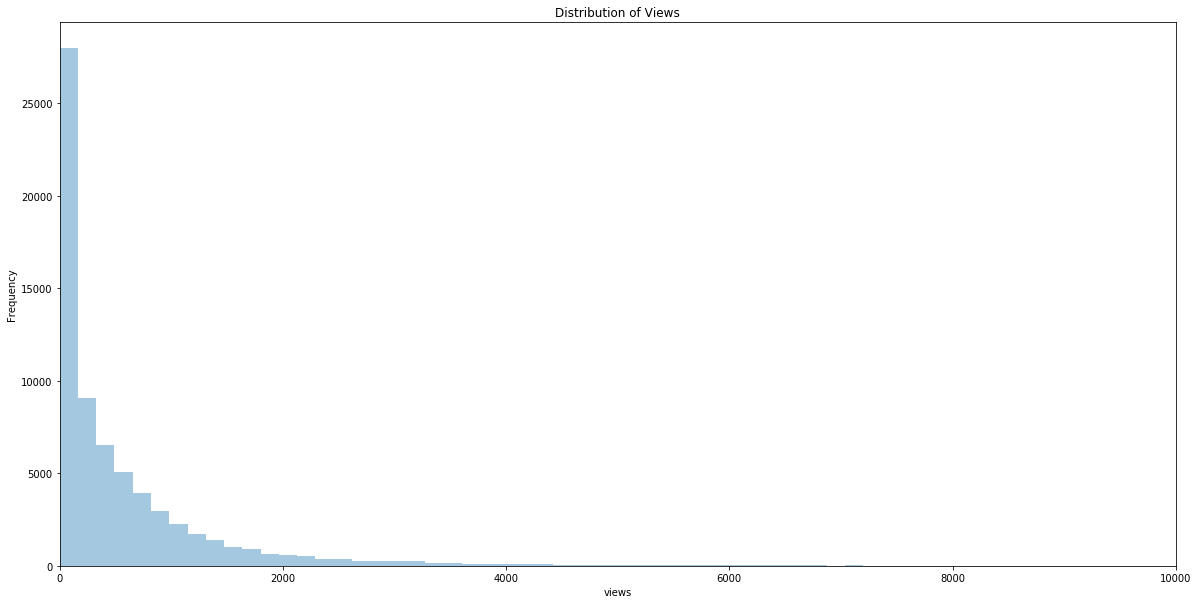

In [19]:
fig, ax = plt.subplots(figsize=(20,10));

sns.distplot(df.views, bins=300, kde=False)

ax.set_title("Distribution of Views")
ax.set_ylabel("Frequency")

ax.set_xlim(0, 10000);


# Distribution of Tag Counts

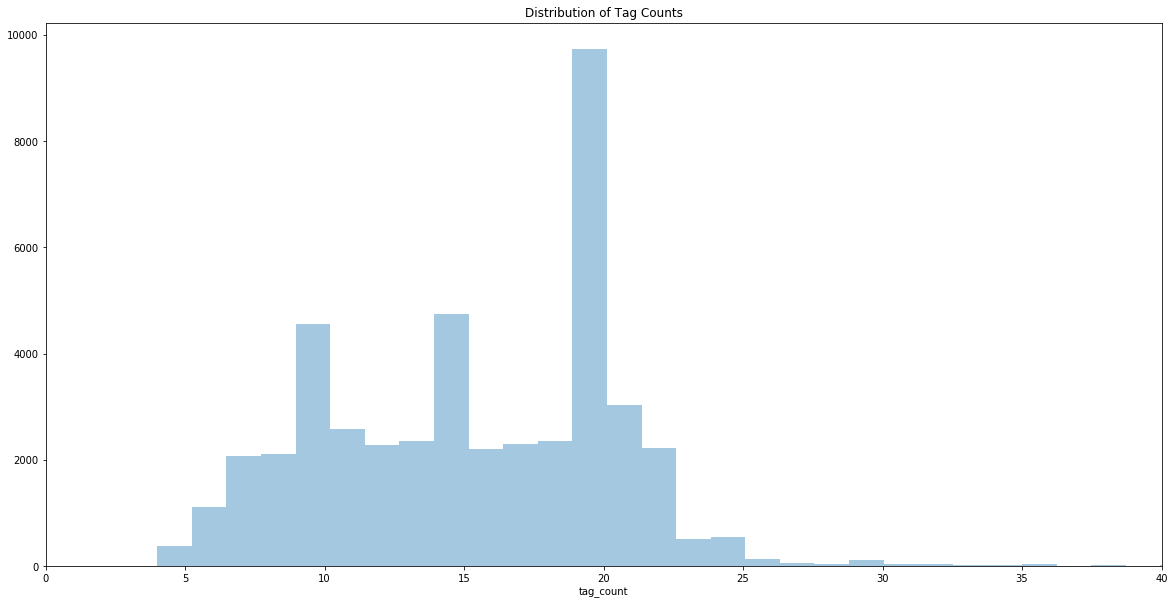

In [248]:
fig, ax = plt.subplots(figsize=(20,10));

sns.distplot(df.tag_count, bins=100, kde=False)

ax.set_title("Distribution of Tag Counts")
ax.set_xlim(0, 40);

In [ ]:
df['class'].value_counts().plot('barh').invert_yaxis()

Here we break the tags into two buckets: [5, 10] and [15, 20] tag_counts respectively

#### $H_0$= The number of views tag counts from the [5,10] bin does not differ from the [15,20] tag count bin.
#### $H_A$= The number of views differs

$\alpha$ = 0.2

In [25]:
alpha = 0.2

In [20]:
df.loc[(df.tag_count <= 10) & (df.tag_count >= 5), 'tag_bucket'] = "5-10"
df.loc[(df.tag_count <= 20) & (df.tag_count >= 15), 'tag_bucket'] = "15-20"

Here we see the 5-10 tag category contains over 10,000 records and the 15-20 tag category contains 18,000 records. This is a much better balance than the original slice of [0:5] and [5:]

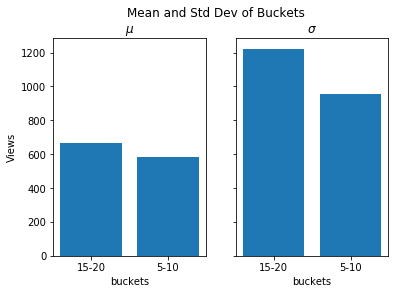

In [21]:
fig, axs = plt.subplots(1,2, sharey=True)

plt.suptitle('Mean and Std Dev of Buckets', y=.99)

axs[0].bar(df.groupby('tag_bucket')['views'].mean().index, df.groupby('tag_bucket')['views'].mean())
axs[0].set_title('$\mu$')
axs[1].bar(df.groupby('tag_bucket')['views'].std().index, df.groupby('tag_bucket')['views'].std())
axs[1].set_title('$\sigma$')
axs[0].set_xlabel('buckets')
axs[1].set_xlabel('buckets')
axs[0].set_ylabel('Views');

In [22]:
five_to_ten = df[df['tag_bucket'] == "5-10"]['views']
fifteen_to_twenty = df[df['tag_bucket'] == "15-20"]['views']

### Perform a T-Test to calculate the T-Statistic and evaluate for the p-value

In [49]:
tstat, pval = stats.ttest_ind(five_to_ten, fifteen_to_twenty, equal_var=False)

print(f"T-Statistic: {tstat}, P-Value: {pval}, P < alpha: {pval < alpha}")

T-Statistic: -7.698108109328321, P-Value: 1.4143692004864982e-14, P < alpha: True


In [50]:
stats.ks_2samp(five_to_ten, fifteen_to_twenty, alternative='less')

Ks_2sampResult(statistic=0.040260062966528565, pvalue=1.409790749779635e-14)

In [51]:
stats.anderson_ksamp([five_to_ten, fifteen_to_twenty])

Anderson_ksampResult(statistic=46.689500638621936, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

We'll now run a Spearman[1] correlation to tease out another p-value given the 



[1] Zwillinger, D. and Kokoska, S. (2000). CRC Standard
   Probability and Statistics Tables and Formulae. Chapman & Hall: New
   York. 2000.
   Section  14.7

In [52]:
stats.spearmanr(df['tag_count'], df['views'])

SpearmanrResult(correlation=0.007669246248898264, pvalue=0.0454505261405618)

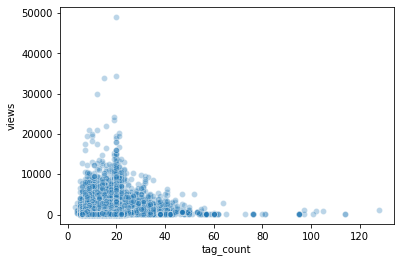

In [97]:
sns.scatterplot(df.tag_count, df.views, alpha=0.3);

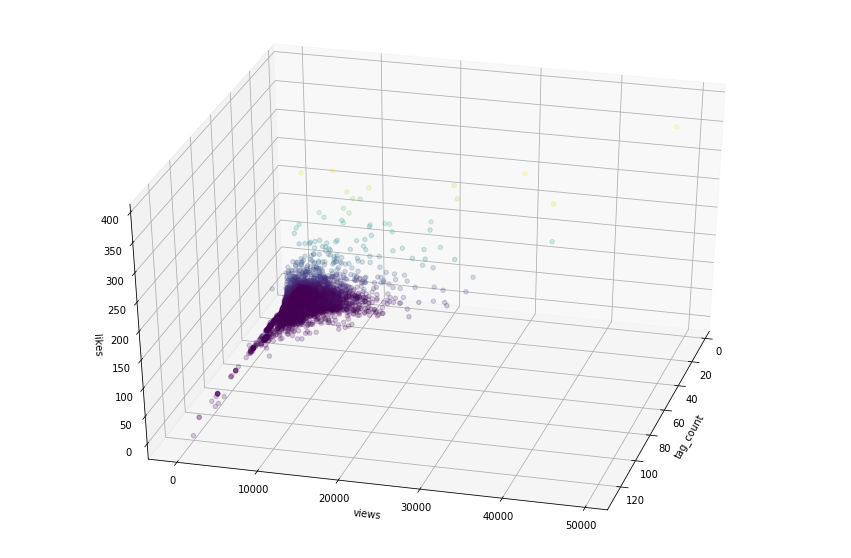

In [168]:
from mpl_toolkits.mplot3d import Axes3D

cmap = plt.cm.viridis(df['likes'])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['tag_count'], df['views'], df['likes'], c=cmap, alpha=0.2)
ax.view_init(35, 15)
ax.set_xlabel('tag_count')
ax.set_ylabel('views')
ax.set_zlabel('likes');

#fig.colorbar()

In [314]:
from scipy import special

In [60]:
five_to_ten_means = []
fifteen_to_twenty_means = []

for _ in range(10**4):
    five_to_ten_means.append(np.mean(five_to_ten.sample(n=5000)))
    fifteen_to_twenty_means.append(np.mean(fifteen_to_twenty.sample(n=5000)))

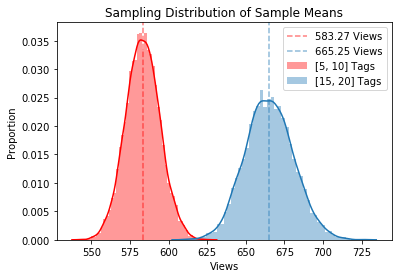

In [83]:
fig, ax = plt.subplots()

sns.distplot(five_to_ten_means, bins=50, color='red', label='[5, 10] Tags')
sns.distplot(fifteen_to_twenty_means, bins=50, label='[15, 20] Tags')

exp_ftten = np.mean(five_to_ten_means)
exp_fttwenty = np.mean(fifteen_to_twenty_means)

ax.axvline(exp_ftten, label=f'{round(exp_ftten,2)} Views', linestyle='--', color='red', alpha=0.5)
ax.axvline(exp_fttwenty, label=f'{round(exp_fttwenty, 2)} Views', linestyle='--', alpha=0.5)
ax.set_xlabel('Views')
ax.set_ylabel('Proportion')
ax.legend()
ax.set_title('Sampling Distribution of Sample Means');


(0, 10000)

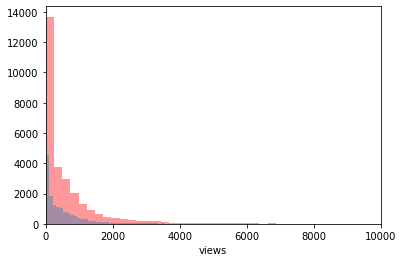

In [62]:
fig, ax = plt.subplots()

sns.distplot(fifteen_to_twenty, bins=200, color='red', kde=False, label='')
sns.distplot(five_to_ten, bins=200, kde=False);

ax.set_xlim(0, 10000)

0.48260960141318465


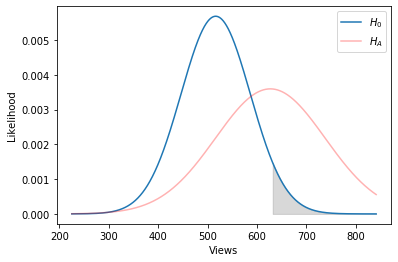

In [185]:
fig, ax = plt.subplots()

x = np.linspace(null_samples.min(), null_samples.max(),len(null_samples))

ax.plot(x, null_dist.pdf(x), label='$H_0$')
ax.fill_between(x, null_dist.pdf(x), where=(x >= null_dist.ppf(0.95)), color='gray', alpha=0.3)

x2 = np.linspace(alt_samples.min(), alt_samples.max(), len(alt_samples))
ax.plot(x, alt_dist.pdf(x), color='red', alpha=0.3, label='$H_A$');

critical_value = null_dist.ppf(0.95)
power = 1 - alt_dist.cdf(critical_value)

ax.set_ylabel('Likelihood')
ax.set_xlabel('Views')
ax.legend()

print(power)

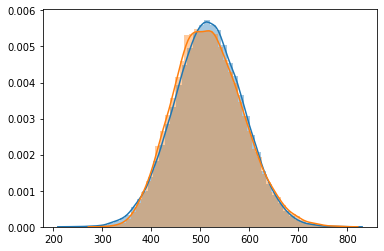

In [75]:
sns.distplot(null_dist.rvs(10**5))
sns.distplot(lte5_means, bins=50);

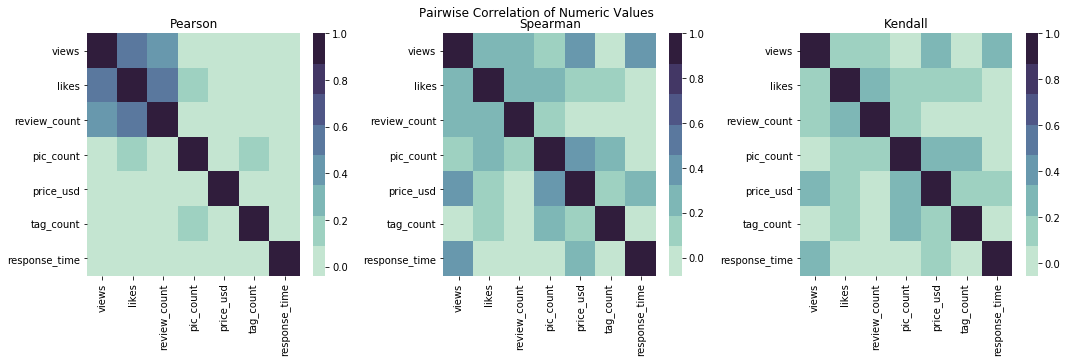

In [84]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.heatmap(df.corr(), cmap=sns.cubehelix_palette(8, start=.5, rot=-.55), ax=axs[0])
axs[0].set_title('Pearson')

sns.heatmap(df.corr('spearman'), cmap=sns.cubehelix_palette(8, start=.5, rot=-.55), ax=axs[1])
axs[1].set_title('Spearman')

sns.heatmap(df.corr('kendall'), cmap=sns.cubehelix_palette(8, start=.5, rot=-.55), ax=axs[2])
axs[2].set_title('Kendall')



plt.tight_layout()
            
plt.suptitle('Pairwise Correlation of Numeric Values', y=1);

Correlation refers to the extend to which two variables have a linear relationship with each other.

Viewing the correlations above, we should note that Pearson's R excels at continuous distributions and assumes variables come from a normally distributed population.
Spearman on the other hand assumes no such thing and can even calculate correlations between categorical variables. The Kendall correlation is used to measure the ordinal
association between two measured quantities.

Correlations are sensitive to outliers as well and extra care should be taken in data prep prior to usage.

In [86]:
mean_price_by_num_tags = df.groupby('tag_count').agg(np.mean)['price_usd']

In [87]:
df['tag_quantiles'] = pd.cut(df['tag_count'], df['tag_count'].quantile(np.linspace(0, 1, 10)))

In [88]:
mean_price_by_tag_quantiles = df.groupby('tag_quantiles').agg(np.mean)['price_usd']

Text(0, 0.5, 'price_usd')

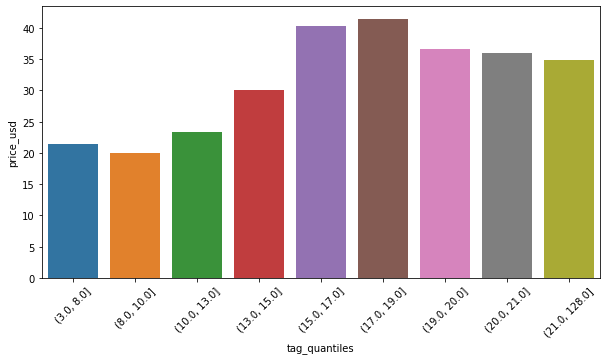

In [91]:
fig, ax = plt.subplots(figsize=(10,5))

#num_tags_mean_price = num_tags_mean_price.sort_values(ascending=False)

sns.barplot(mean_price_by_tag_quantiles.index, mean_price_by_tag_quantiles.values)
ax.set_xticklabels(mean_price_by_tag_quantiles.index, rotation=45)
ax.set_ylabel('price_usd')

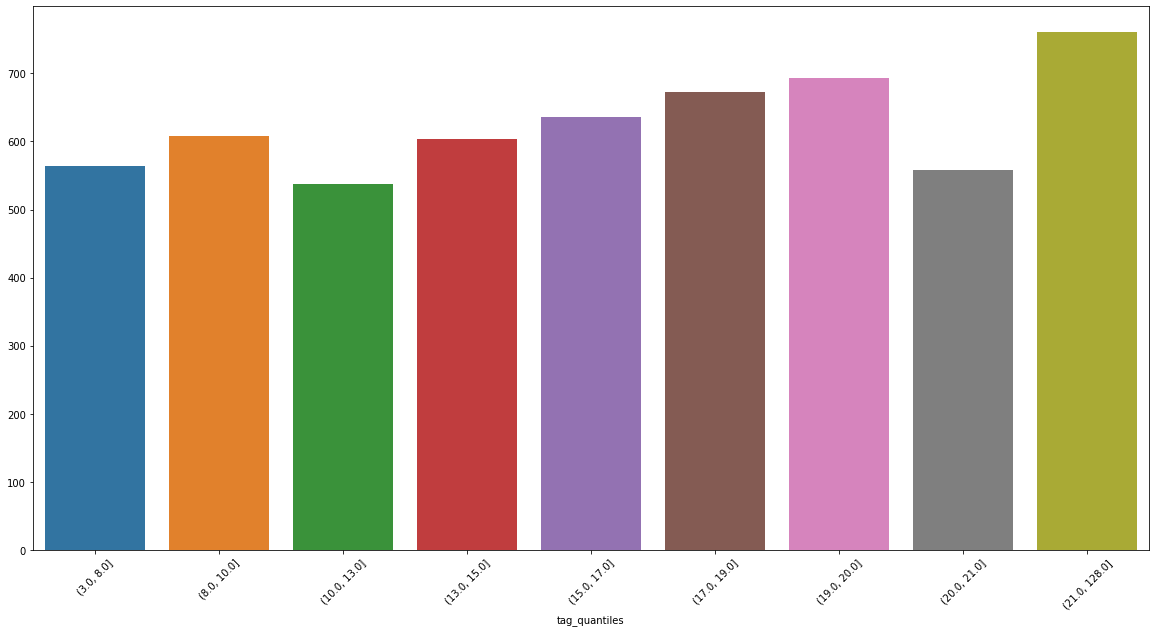

In [92]:
fig, ax = plt.subplots(figsize=(20,10))

mean_views_by_tag_quantiles = df.groupby('tag_quantiles').agg(np.mean)['views']

sns.barplot(mean_views_by_tag_quantiles.index, mean_views_by_tag_quantiles.values)
ax.set_xticklabels(mean_views_by_tag_quantiles.index, rotation=45);

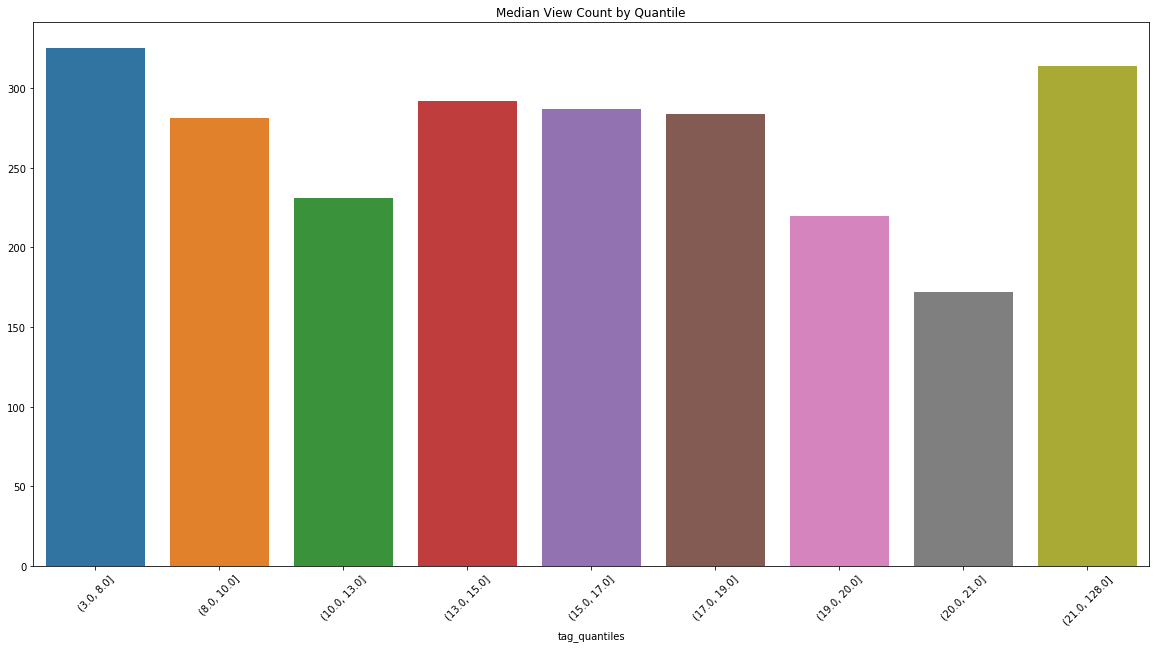

In [93]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_title('Median View Count by Quantile')

median_views_by_tag_quantiles = df.groupby('tag_quantiles').agg(np.median)['views']

sns.barplot(median_views_by_tag_quantiles.index, median_views_by_tag_quantiles.values)
ax.set_xticklabels(median_views_by_tag_quantiles.index, rotation=45);

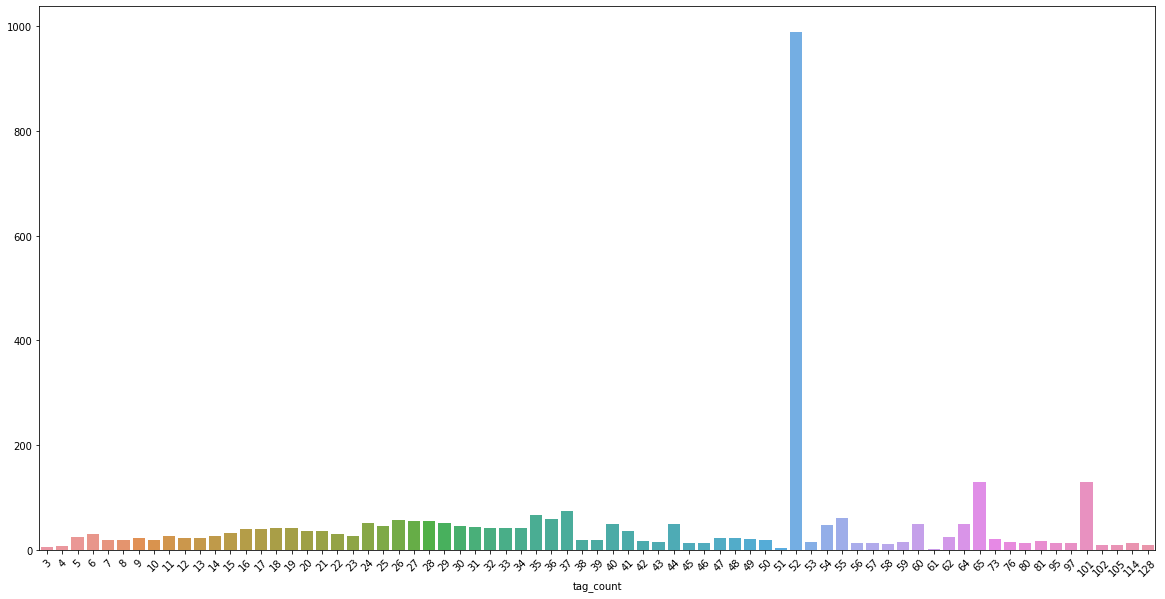

In [94]:
fig, ax = plt.subplots(figsize=(20,10))

#num_tags_mean_price = num_tags_mean_price.sort_values(ascending=False)

sns.barplot(mean_price_by_num_tags.index, mean_price_by_num_tags.values)
ax.set_xticklabels(mean_price_by_num_tags.index, rotation=45);

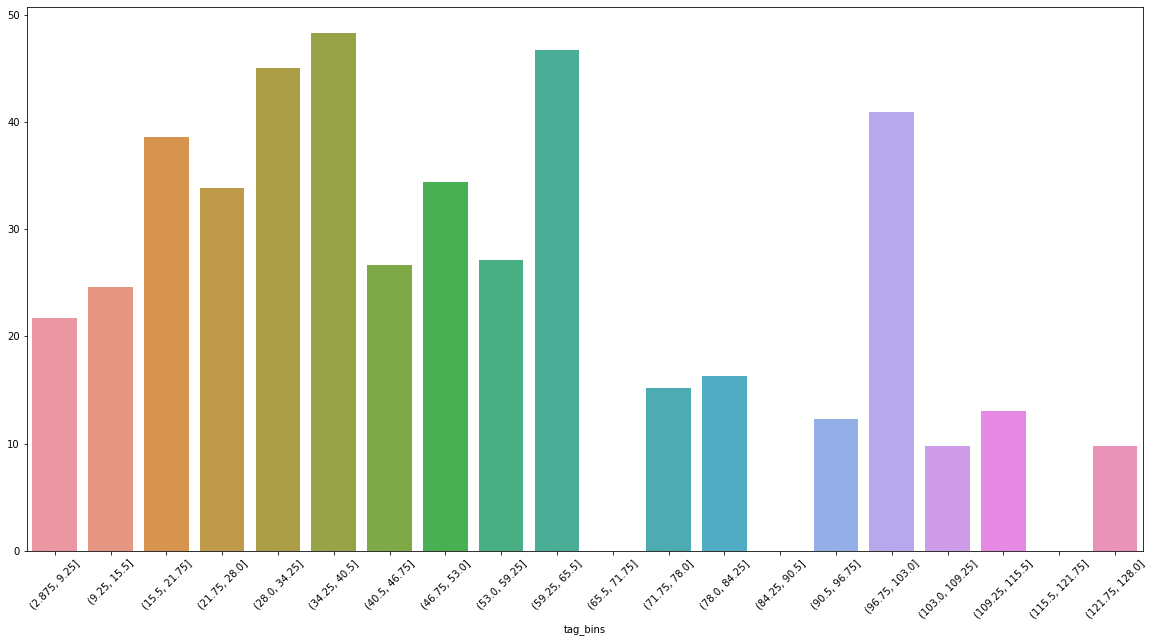

In [95]:
df['tag_bins'] = pd.cut(df['tags'].agg(len), bins=20)

num_tags_mean_price = df.groupby('tag_bins').mean()['price_usd']

fig, ax = plt.subplots(figsize=(20,10))

#num_tags_mean_price = num_tags_mean_price.sort_values(ascending=False)

sns.barplot(num_tags_mean_price.index, num_tags_mean_price.values)
ax.set_xticklabels(num_tags_mean_price.index, rotation=45);

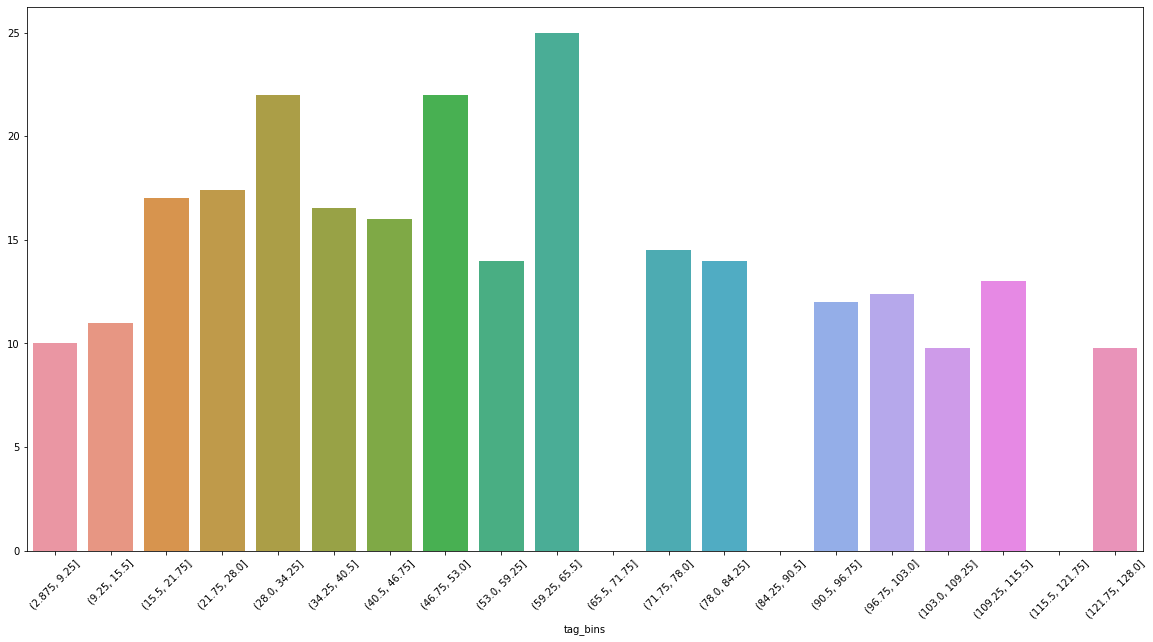

In [96]:
num_tags_median_price = df.groupby('tag_bins').median()['price_usd']

fig, ax = plt.subplots(figsize=(20,10))

#num_tags_median_price = num_tags_median_price.sort_values(ascending=False)

sns.barplot(num_tags_median_price.index, num_tags_median_price.values)
ax.set_xticklabels(num_tags_median_price.index, rotation=45);